# Nov 23, 2025: align modes
agglomerative hierarchical clustering

hungarian + statistical testing for missing modes

conda env: gt

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats
from scipy.spatial.distance import jensenshannon, squareform, pdist, cdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.optimize import linear_sum_assignment
from scipy.stats import pearsonr, gaussian_kde, ranksums, wilcoxon

from typing import Tuple

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc
import cmcrameri.cm as cmc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

load membership matrices

In [11]:
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-SLC01/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
grp_df = []
for file in indiv_files:
    with open(file, 'rb') as f:
        df = pickle.load(f)
    grp_df += [df]

In [12]:
boot_files = sorted(glob.glob(f'{ESTIM_path_boot}/individual/boot-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 180/180 [00:00<00:00, 878.84it/s]


In [13]:
pis_df = pd.concat(grp_df + boots_df).reset_index(drop=True)
# pis_df

In [14]:
def make_same_shape(Ms: list):
    num_rois = Ms[0].shape[0]
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    return Rs

In [15]:
cols = [c for c in pis_df.columns if 'pi' in c]

In [16]:
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [17]:
pis_df

sub       sbm     omega  \
0     grp  sbm-nd-h  0.257972   
1     grp  sbm-nd-h  0.141756   
2     grp  sbm-nd-h  0.126375   
3     grp  sbm-nd-h  0.121384   
4     grp  sbm-nd-h  0.076945   
...   ...       ...       ...   
2050  209  sbm-nd-h  0.076194   
2051  209  sbm-nd-h  0.040722   
2052  209  sbm-nd-h  0.024532   
2053  209  sbm-nd-h  0.019268   
2054  209  sbm-nd-h  0.000013   

                                           pi_0_aligned  \
0     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
2050  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2051  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2052  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2053  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           pi_1_aligned  \
0     [[0.9496124031007752, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.9014084507042254, 0.0, 0.03521126760563380...   
2     [[0.9603174603174603, 0.0, 0.02380952380952380...   
3     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[0.948051948051948, 0.0, 0.03896103896103896,...   
...                                                 ...   
2050  [[0.868421052631579, 0.0, 0.11842105263157894,...   
2051  [[0.9512195121951219, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2052  [[0.76, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
2053  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           pi_2_aligned  \
0     [[0.6437608598092126, 0.2606665861170884, 0.0,...   
1     [[0.6115267878457183, 0.30154827268696927, 0.0...   
2     [[0.8449231544469641, 0.15309271856890905, 0.0...   
3     [[0.7768595041322314, 0.1487603305785124, 0.0,...   
4     [[0.27648667122351334, 0.5488721804511278, 0.0...   
...                                                 ...   
2050  [[0.8057160555256558, 0.16873990881119452, 0.0...   
2051  [[0.9257244837256735, 0.04410639925214583, 0.0...   
2052  [[0.8480000000000001, 0.1216, 0.0, 0.0304, 0.0...   
2053  [[0.6315789473684211, 0.26315789473684215, 0.0...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           pi_3_aligned  \
0     [[0.9168790597020432, 0.052194539288673784, 0....   
1     [[0.9230675026525829, 0.03443822159502731, 0.0...   
2     [[0.988518046107332, 0.0, 0.011481953892668179...   
3     [[0.8821478742590688, 0.08346424424561164, 0.0...   
4     [[0.9308030998393267, 0.0071814719798315154, 0...   
...                                                 ...   
2050  [[0.9103727081592926, 0.06360916227834125, 0.0...   
2051  [[0.9751594874271563, 0.022578645944528623, 0....   
2052  [[0.8931733333333335, 0.10176, 0.0050666666666...   
2053  [[0.9667590027700832, 0.0332409972299169, 0.0,...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....   

                                           pi_4_aligned  \
0     [[0.9895747322406524, 0.003054686556059629, 0....   
1     [[0.9846480718880001, 0.01061789692559751, 0.0...   
2     [[1.0000000000000002, 0.0, 0.0, 0.0], [1.0, 0....   
3     [[0.998659816841635, 0.0013401831583649765, 0....   
4     [[0.9849774968708667, 0.007128210135728934, 0....   
...                                                 ...   
2050  [[0.9762009473101244, 0.0025959985970953003, 0...   
2051  [[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....   
2052  [[1.0000000000000002, 0.0, 0.0, 0.0], [1.0, 0....   
2053  [[0.9667590027700832, 0.0, 0.0, 0.033240997229...   
2054  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                                           pi_5_aligned  \
0    

In [18]:
def keep_select_comms(args: ARGS, Ms: list):
    Ms = np.stack(Ms)
    Ms = Ms[:, :, args.select_comms]
    return [Ms[i, :, :] for i in range(Ms.shape[0])]

In [19]:
if args.sbm in ['h']:
    args.select_comms = np.arange(0, 9) # for pi_1_aligned only
    args.num_comms = len(args.select_comms)
    i = 1
    cols1 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) < i]
    cols2 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) > i]
    pis_df = pd.concat(
        [
            pis_df[['sub', 'sbm', 'omega']],
            pis_df[cols1],
            pis_df[cols[i:i+1]].apply(lambda pis: keep_select_comms(args, pis.to_list())),
            pis_df[cols2],
        ],
        axis=1
    )
else:
    args.select_comms = np.arange(0, 9)
    args.num_comms = len(args.select_comms)
    pis_df = pd.concat(
        [
            pis_df[['sub', 'sbm', 'omega']],
            pis_df[cols].apply(lambda pis: keep_select_comms(args, pis.to_list())),
        ],
        axis=1,
    )

In [20]:
pis_df

sub       sbm     omega  \
0     grp  sbm-nd-h  0.257972   
1     grp  sbm-nd-h  0.141756   
2     grp  sbm-nd-h  0.126375   
3     grp  sbm-nd-h  0.121384   
4     grp  sbm-nd-h  0.076945   
...   ...       ...       ...   
2050  209  sbm-nd-h  0.076194   
2051  209  sbm-nd-h  0.040722   
2052  209  sbm-nd-h  0.024532   
2053  209  sbm-nd-h  0.019268   
2054  209  sbm-nd-h  0.000013   

                                           pi_0_aligned  \
0     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
2050  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2051  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2052  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2053  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           pi_1_aligned  \
0     [[0.9496124031007752, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.9014084507042254, 0.0, 0.03521126760563380...   
2     [[0.9603174603174603, 0.0, 0.02380952380952380...   
3     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
4     [[0.948051948051948, 0.0, 0.03896103896103896,...   
...                                                 ...   
2050  [[0.868421052631579, 0.0, 0.11842105263157894,...   
2051  [[0.9512195121951219, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2052  [[0.76, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
2053  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   

                                           pi_2_aligned  \
0     [[0.6437608598092126, 0.2606665861170884, 0.0,...   
1     [[0.6115267878457183, 0.30154827268696927, 0.0...   
2     [[0.8449231544469641, 0.15309271856890905, 0.0...   
3     [[0.7768595041322314, 0.1487603305785124, 0.0,...   
4     [[0.27648667122351334, 0.5488721804511278, 0.0...   
...                                                 ...   
2050  [[0.8057160555256558, 0.16873990881119452, 0.0...   
2051  [[0.9257244837256735, 0.04410639925214583, 0.0...   
2052  [[0.8480000000000001, 0.1216, 0.0, 0.0304, 0.0...   
2053  [[0.6315789473684211, 0.26315789473684215, 0.0...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           pi_3_aligned  \
0     [[0.9168790597020432, 0.052194539288673784, 0....   
1     [[0.9230675026525829, 0.03443822159502731, 0.0...   
2     [[0.988518046107332, 0.0, 0.011481953892668179...   
3     [[0.8821478742590688, 0.08346424424561164, 0.0...   
4     [[0.9308030998393267, 0.0071814719798315154, 0...   
...                                                 ...   
2050  [[0.9103727081592926, 0.06360916227834125, 0.0...   
2051  [[0.9751594874271563, 0.022578645944528623, 0....   
2052  [[0.8931733333333335, 0.10176, 0.0050666666666...   
2053  [[0.9667590027700832, 0.0332409972299169, 0.0,...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....   

                                           pi_4_aligned  \
0     [[0.9895747322406524, 0.003054686556059629, 0....   
1     [[0.9846480718880001, 0.01061789692559751, 0.0...   
2     [[1.0000000000000002, 0.0, 0.0, 0.0], [1.0, 0....   
3     [[0.998659816841635, 0.0013401831583649765, 0....   
4     [[0.9849774968708667, 0.007128210135728934, 0....   
...                                                 ...   
2050  [[0.9762009473101244, 0.0025959985970953003, 0...   
2051  [[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....   
2052  [[1.0000000000000002, 0.0, 0.0, 0.0], [1.0, 0....   
2053  [[0.9667590027700832, 0.0, 0.0, 0.033240997229...   
2054  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                                           pi_5_aligned  \
0    

In [21]:
if args.sbm in ['h']: 
    col = cols[1]
else:
    col = cols[0]
col

'pi_1_aligned'

In [22]:
level = col.replace('pi_', '').replace('_aligned', '')
level

'1'

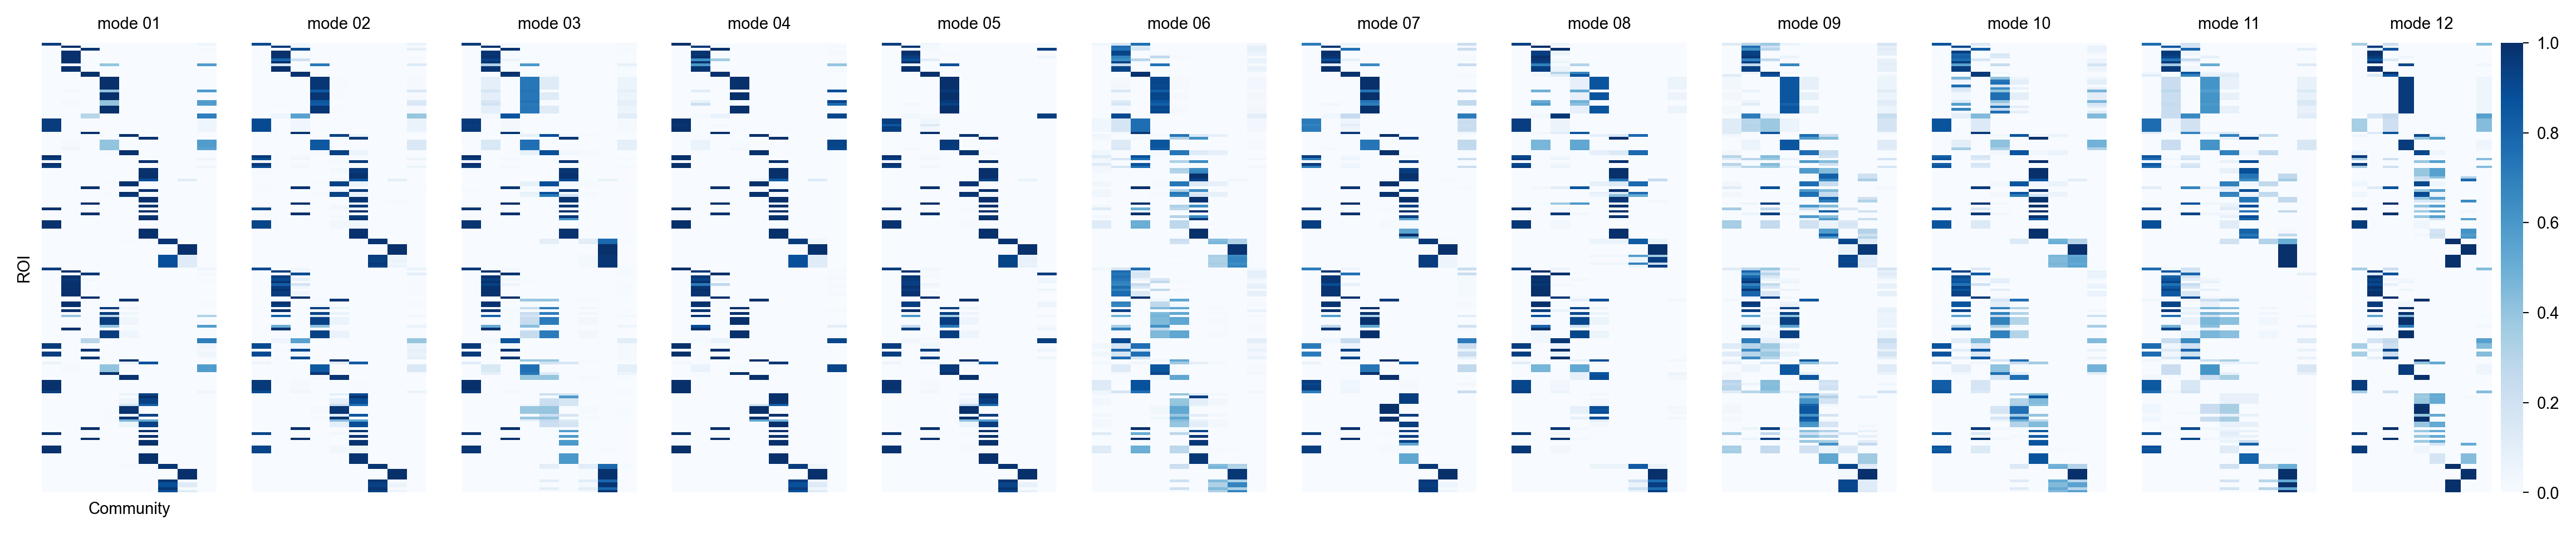

In [23]:
pis_ref = pis_df[pis_df['sub'].isin(['grp'])][col].to_list()
nrows = 1
ncols = len(pis_ref)
fig, axs = plt.subplots(nrows, ncols, figsize=(1.6*ncols, 3.5*nrows))
for idx_pi, pi in enumerate(pis_ref):
    ax = axs[idx_pi]
    sns.heatmap(pi, ax=ax, cbar=False if idx_pi < ncols-1 else True, cmap='Blues')
    ax.set(
        title=f'mode {idx_pi+1:02d}', 
        yticks=[], xticks=[],
        xlabel=f'Community' if idx_pi == 0 else '',
        ylabel=f'ROI' if idx_pi == 0 else '',
    )

In [24]:
pi.sum(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.95652174, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.95652174, 1.        ,
       0.95652174, 0.95652174, 1.        , 0.95652174, 0.95652174,
       0.95652174, 0.97353497, 1.        , 1.        , 1.        ,
       1.        , 0.95652174, 1.        , 0.99810964, 0.95652174,
       0.98676749, 1.        , 0.95652174, 1.        , 0.9584121 ,
       1.        , 0.95652174, 0.72778828, 1.        , 1.        ,
       1.        , 0.79584121, 0.79584121, 0.82608696, 0.79584

In [25]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes.png', transparent=True, dpi=300, bbox_inches='tight')

center the matrices: remove the mean pi: work with residuals to amplify the differences: like data centering done before PCA or k-means clustering

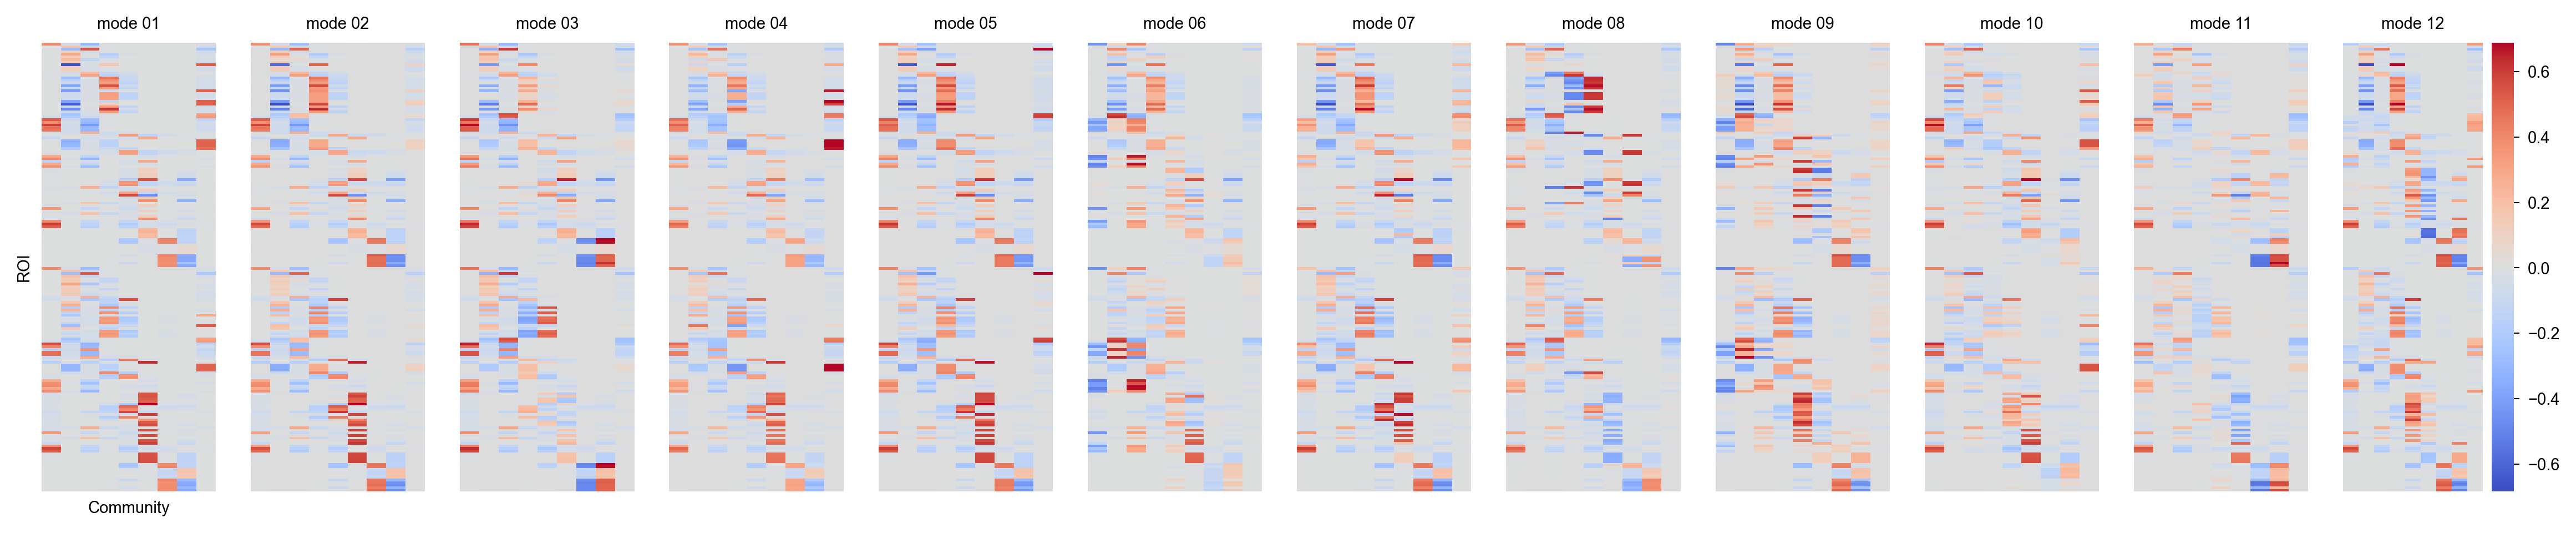

In [26]:
mean_pi = pis_df[col].mean()
pis_df[f'{col}_residual'] = pis_df[col].apply(lambda pi: pi - mean_pi)


pis_ref = pis_df[pis_df['sub'].isin(['grp'])][f'{col}_residual'].to_list()
nrows = 1
ncols = len(pis_ref)
fig, axs = plt.subplots(nrows, ncols, figsize=(1.6*ncols, 3.5*nrows))
for idx_pi, pi in enumerate(pis_ref):
    ax = axs[idx_pi]
    sns.heatmap(pi, ax=ax, cbar=False if idx_pi < ncols-1 else True, cmap='coolwarm', center=0)
    ax.set(
        title=f'mode {idx_pi+1:02d}', 
        yticks=[], xticks=[],
        xlabel=f'Community' if idx_pi == 0 else '',
        ylabel=f'ROI' if idx_pi == 0 else '',
    )

In [27]:
pis_df

sub       sbm     omega  \
0     grp  sbm-nd-h  0.257972   
1     grp  sbm-nd-h  0.141756   
2     grp  sbm-nd-h  0.126375   
3     grp  sbm-nd-h  0.121384   
4     grp  sbm-nd-h  0.076945   
...   ...       ...       ...   
2050  209  sbm-nd-h  0.076194   
2051  209  sbm-nd-h  0.040722   
2052  209  sbm-nd-h  0.024532   
2053  209  sbm-nd-h  0.019268   
2054  209  sbm-nd-h  0.000013   

                                           pi_0_aligned  \
0     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
...                                                 ...   
2050  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2051  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2052  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2053  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           pi_1_aligned  \
0     [[0.9496124031007752, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1     [[0.9014084507042254, 0.0, 0.03521126760563380...   
2     [[0.9603174603174603, 0.0, 0.02380952380952380...   
3     [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
4     [[0.948051948051948, 0.0, 0.03896103896103896,...   
...                                                 ...   
2050  [[0.868421052631579, 0.0, 0.11842105263157894,...   
2051  [[0.9512195121951219, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2052  [[0.76, 0.0, 0.12, 0.0, 0.0, 0.0, 0.0, 0.0, 0....   
2053  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   

                                           pi_2_aligned  \
0     [[0.6437608598092126, 0.2606665861170884, 0.0,...   
1     [[0.6115267878457183, 0.30154827268696927, 0.0...   
2     [[0.8449231544469641, 0.15309271856890905, 0.0...   
3     [[0.7768595041322314, 0.1487603305785124, 0.0,...   
4     [[0.27648667122351334, 0.5488721804511278, 0.0...   
...                                                 ...   
2050  [[0.8057160555256558, 0.16873990881119452, 0.0...   
2051  [[0.9257244837256735, 0.04410639925214583, 0.0...   
2052  [[0.8480000000000001, 0.1216, 0.0, 0.0304, 0.0...   
2053  [[0.6315789473684211, 0.26315789473684215, 0.0...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                           pi_3_aligned  \
0     [[0.9168790597020432, 0.052194539288673784, 0....   
1     [[0.9230675026525829, 0.03443822159502731, 0.0...   
2     [[0.988518046107332, 0.0, 0.011481953892668179...   
3     [[0.8821478742590688, 0.08346424424561164, 0.0...   
4     [[0.9308030998393267, 0.0071814719798315154, 0...   
...                                                 ...   
2050  [[0.9103727081592926, 0.06360916227834125, 0.0...   
2051  [[0.9751594874271563, 0.022578645944528623, 0....   
2052  [[0.8931733333333335, 0.10176, 0.0050666666666...   
2053  [[0.9667590027700832, 0.0332409972299169, 0.0,...   
2054  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0....   

                                           pi_4_aligned  \
0     [[0.9895747322406524, 0.003054686556059629, 0....   
1     [[0.9846480718880001, 0.01061789692559751, 0.0...   
2     [[1.0000000000000002, 0.0, 0.0, 0.0], [1.0, 0....   
3     [[0.998659816841635, 0.0013401831583649765, 0....   
4     [[0.9849774968708667, 0.007128210135728934, 0....   
...                                                 ...   
2050  [[0.9762009473101244, 0.0025959985970953003, 0...   
2051  [[1.0, 0.0, 0.0, 0.0], [0.9999999999999999, 0....   
2052  [[1.0000000000000002, 0.0, 0.0, 0.0], [1.0, 0....   
2053  [[0.9667590027700832, 0.0, 0.0, 0.033240997229...   
2054  [[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...   

                                           pi_5_aligned  \
0    

In [28]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-centered.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-centered.png', transparent=True, dpi=300, bbox_inches='tight')

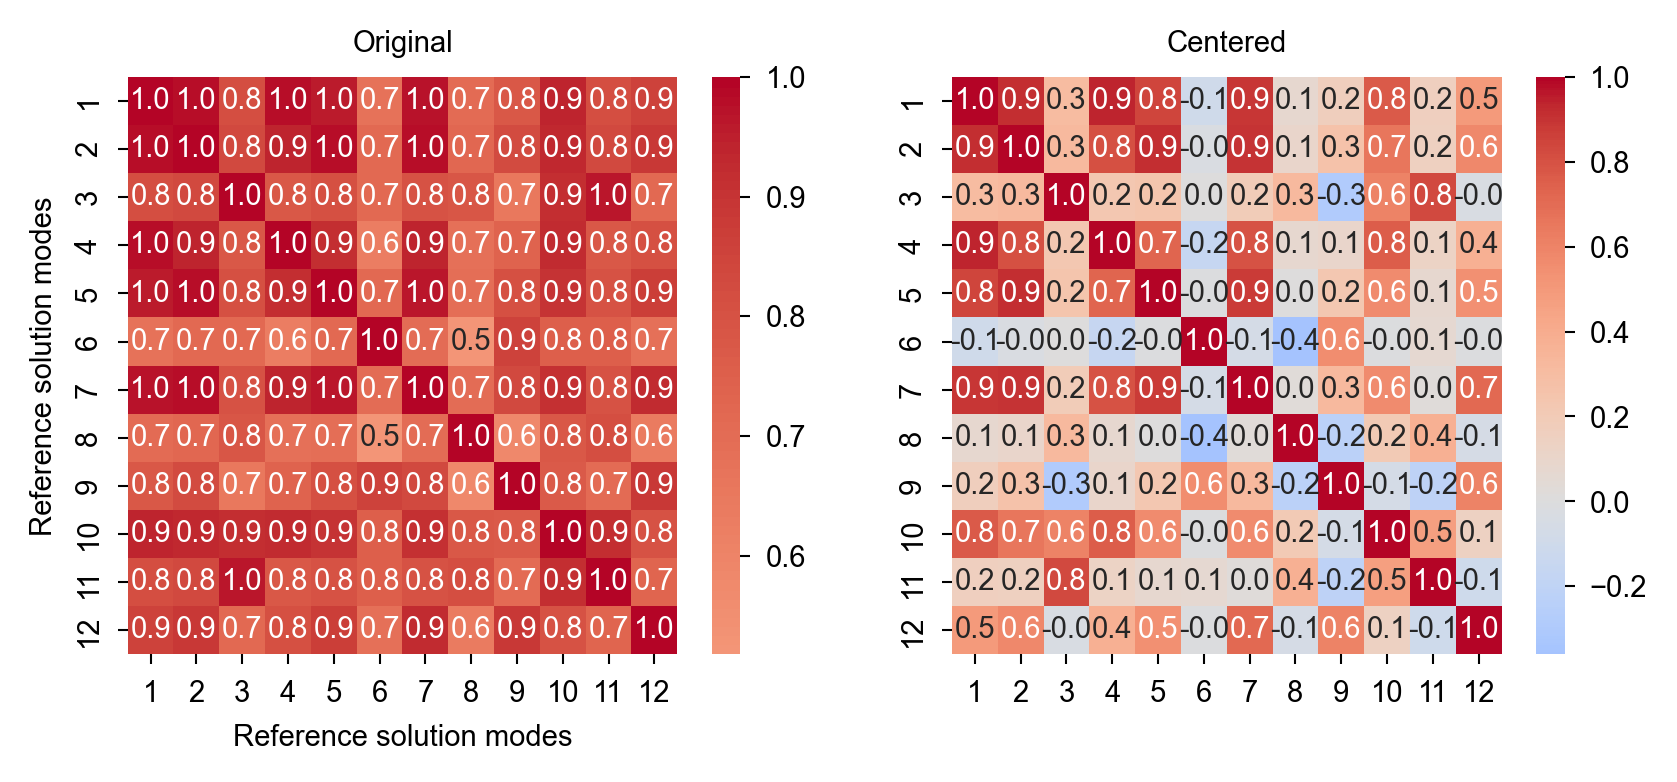

In [29]:
nrows = 1
ncols = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(3.25*ncols, 2.5*nrows))

ax = axs[0]
X = np.stack(pis_df[pis_df['sub'].isin(['grp'])][col].apply(lambda pi: pi.flatten()).to_list())
corr_mat = np.corrcoef(X)
sns.heatmap(
    corr_mat, 
    ax=ax, 
    cmap='coolwarm', center=0,
    annot=True, fmt='.1f',
)
_ = ax.set(xticklabels=range(1, X.shape[0]+1), yticklabels=range(1, X.shape[0]+1), title=f'Original', ylabel=f'Reference solution modes', xlabel=f'Reference solution modes')

ax = axs[1]
X = np.stack(pis_df[pis_df['sub'].isin(['grp'])][f'{col}_residual'].apply(lambda pi: pi.flatten()).to_list())
corr_mat = np.corrcoef(X)
sns.heatmap(
    corr_mat, 
    ax=ax, 
    cmap='coolwarm', center=0,
    annot=True, fmt='.1f',
)
_ = ax.set(xticklabels=range(1, X.shape[0]+1), yticklabels=range(1, X.shape[0]+1), title=f'Centered')

In [30]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-correlations.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_desc-reference-solution-modes-correlations.png', transparent=True, dpi=300, bbox_inches='tight')

merge redundant modes

In [31]:
def tvd(pia, pib):
    diff = np.abs(pia - pib)
    row_sum = np.sum(diff, axis=1)
    return 0.5 * np.mean(row_sum)

def pearson_dist(pia, pib):
    r, _ = pearsonr(pia.flatten(), pib.flatten())
    return 1 - r # in the range [0, 2]

def get_dist_mat(mode_list, dist_func=pearson_dist):
    dist_mat = np.zeros((len(mode_list), len(mode_list)))
    for i in range(len(mode_list)):
        for j in range(i+1, len(mode_list)):
            pia = mode_list[i]
            pib = mode_list[j]
            dist_mat[i, j] = dist_func(pia, pib)
            dist_mat[j, i] = dist_mat[i, j]
    return dist_mat

In [32]:
def cluster_and_merge_modes(df: pd.DataFrame, col: str):
    mode_list = df[col].to_list()
    omegas = df['omega'].to_list()
    
    n = len(mode_list)
    if n <= 2: 
        sil_df = pd.DataFrame(dict(
            k=[n],
            labels=[np.arange(1, n+1)],
            score=[1],
        ))
        return sil_df, mode_list, omegas
        
    
    dist_mat = get_dist_mat(mode_list)
    
    dist_vec = squareform(dist_mat, checks=False)
    
    Z = linkage(dist_vec, method='average')
    
    sil_df = []
    for k in range(2, n):
        labels = fcluster(Z, t=k, criterion='maxclust')
        score = silhouette_score(dist_mat, labels, metric='precomputed') 
        row = pd.DataFrame(dict(
            k=[k],
            labels=[labels],
            score=[score],
        ))
        sil_df += [row]
    sil_df = pd.concat(sil_df).reset_index(drop=True)
    
    best_score = np.argmax(sil_df['score'])
    best_labels = sil_df['labels'][best_score]
    
    merged_modes = []
    unique_labels = np.unique(best_labels)
    for lbl in unique_labels:
        idxs = np.where(best_labels == lbl)[0]
        cluster_pis = [mode_list[i] for i in idxs]
        mean_pi = np.mean(cluster_pis, axis=0)
        # rsum = mean_pi.sum(axis=1)[:, np.newaxis]
        # mean_pi = np.nan_to_num(mean_pi / rsum)
        merged_modes.append(mean_pi)
    
    merged_omegas = np.bincount(best_labels, omegas)[1:] # ignore the 0th count, which is anyways 0
    return sil_df, merged_modes, merged_omegas

In [33]:
if args.sbm in ['h']:
    col = f'{cols[1]}_residual'
else:
    col = f'{cols[0]}_residual'
col

'pi_1_aligned_residual'

In [34]:
merged_pis_df = []
for [sub], group in pis_df.groupby(by=['sub']):
    sil_df, merged_modes, merged_omegas = cluster_and_merge_modes(group, col)
    
    row = pd.DataFrame(dict(
        sub=[group['sub'].to_list()[0]]*len(merged_omegas),
        sbm=[group['sbm'].to_list()[0]]*len(merged_omegas),
        omega=merged_omegas,
        pi=merged_modes,
        sil=[sil_df]*len(merged_omegas),
    ))
    row.sort_values(by='omega', ascending=False, inplace=True)
    merged_pis_df += [row]
merged_pis_df = pd.concat(merged_pis_df).reset_index(drop=True)
merged_pis_df

sub       sbm     omega  \
0     00  sbm-nd-h  0.500108   
1     00  sbm-nd-h  0.191246   
2     00  sbm-nd-h  0.142725   
3     00  sbm-nd-h  0.132811   
4     00  sbm-nd-h  0.031086   
..   ...       ...       ...   
565  grp  sbm-nd-h  0.683759   
566  grp  sbm-nd-h  0.152146   
567  grp  sbm-nd-h  0.071034   
568  grp  sbm-nd-h  0.057237   
569  grp  sbm-nd-h  0.035825   

                                                    pi  \
0    [[-0.4912406425979005, -0.04243316412728488, 0...   
1    [[0.34206284774625323, -0.04660824830236906, -...   
2    [[0.3156443535329003, -0.04660824830236906, -0...   
3    [[0.31326868922190143, -0.03813587316693164, -...   
4    [[-0.0804489077396402, -0.04660824830236906, 0...   
..                                                 ...   
565  [[0.36318294526428324, -0.04660824830236906, -...   
566  [[0.33205247976174734, -0.027377479071599826, ...   
567  [[-0.4904681138856069, 0.12240583620467319, 0....   
568  [[-0.30166573439124944, 0.09624889455477378, -...   
569  [[0.41172280943207695, -0.04660824830236906, -...   

                                                   sil  
0         k                                        ...  
1         k                                        ...  
2         k                                        ...  
3         k                                        ...  
4         k                                        ...  
..                                                 ...  
565      k                                  labels ...  
566      k                                  labels ...  
567      k                                  labels ...  
568      k                                  labels ...  
569      k                                  labels ...  

[570 rows x 5 columns]

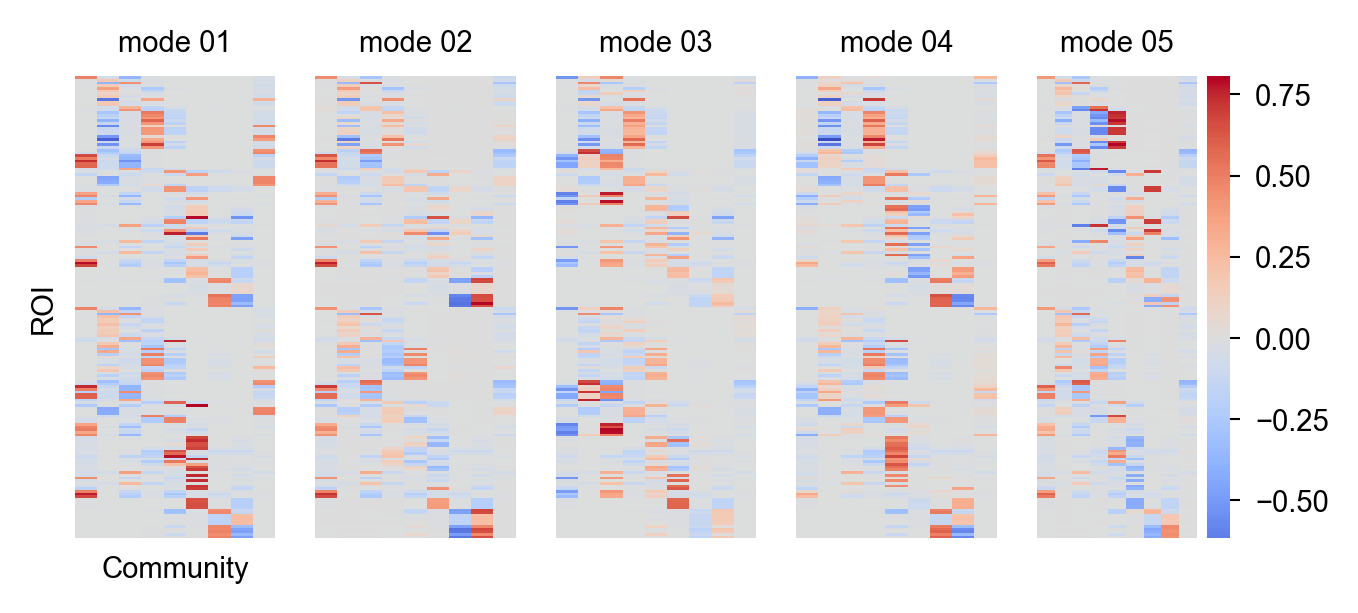

In [35]:
group = merged_pis_df[merged_pis_df['sub'].isin(['grp'])]
merged_modes = group['pi'].to_list() #+ mean_pi
merged_omegas = group['omega'].to_list()
sil_df = group['sil'].to_list()[0]

nrows = 1
ncols = len(merged_modes)
fig, axs = plt.subplots(nrows, ncols, figsize=(1*ncols, 2*nrows))
for idx_pi, pi in enumerate(merged_modes):
    ax = axs[idx_pi] if ncols > 1 else axs
    sns.heatmap(pi, ax=ax, cbar=False if idx_pi < ncols-1 else True, cmap='coolwarm', center=0)
    ax.set(
        title=f'mode {idx_pi+1:02d}', 
        xticks=[], yticks=[], 
        # xlabel=r'$\omega_{k}$' + f' {merged_omegas[idx_pi]:.2f}'
        xlabel=f'Community' if idx_pi == 0 else '',
        ylabel=f'ROI' if idx_pi == 0 else '',
    )

In [36]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-centered.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-centered.png', transparent=True, dpi=300, bbox_inches='tight')

In [37]:
def get_corr_matrix(pis_ref, pis_sample):
    n_ref = len(pis_ref)
    n_boot = len(pis_sample)

    corr_matrix = np.zeros((n_ref, n_boot))

    for i in range(n_ref):
        for j in range(n_boot):
            # Flatten matrices to 1D vectors for correlation
            # This captures the "Global Spatial Similarity"
            r, _ = pearsonr(pis_ref[i].flatten(), pis_sample[j].flatten())
            corr_matrix[i, j] = r
    return corr_matrix

[Text(0.5, 41.3333333333333, 'Reference super-modes'),
 Text(5.333333333333332, 0.5, 'Reference super-modes'),
 Text(0.5, 1.0, 'Pearson correlation')]

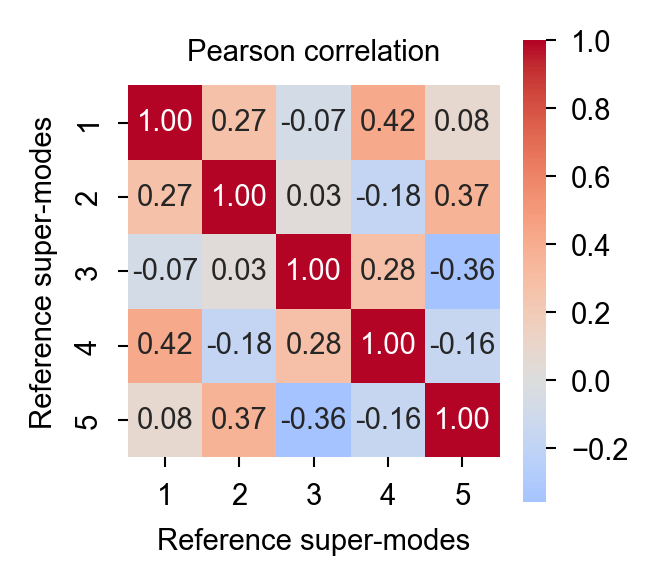

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
sns.heatmap(
    get_corr_matrix(merged_modes, merged_modes), 
    ax=ax, 
    cmap='coolwarm',
    square=True,
    annot=True,
    fmt='.2f',
    center=0,
)
ax.set(xticklabels=range(1, len(group)+1), yticklabels=range(1, len(group)+1))
ax.set(xlabel='Reference super-modes', ylabel='Reference super-modes', title=f'Pearson correlation')

In [39]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-correlations.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-super-modes-correlations.png', transparent=True, dpi=300, bbox_inches='tight')

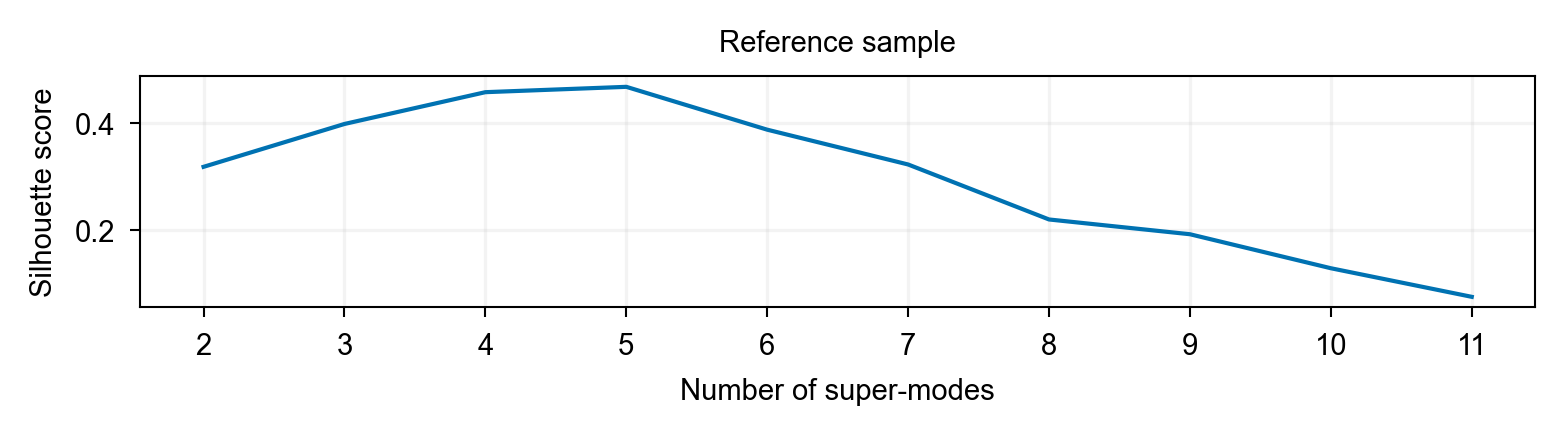

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(6, 1))
ax.plot(sil_df['k'], sil_df['score'])
ax.set(xticks=sil_df['k'], xlabel=f'Number of super-modes', ylabel=f'Silhouette score', title=f'Reference sample')
ax.grid(alpha=0.15)

In [41]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-silhouette-scores.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-reference-silhouette-scores.png', transparent=True, dpi=300, bbox_inches='tight')

In [42]:
merged_pis_df_ = merged_pis_df.copy(deep=True)
merged_pis_df_['pi'] = merged_pis_df_['pi'].apply(lambda pi: pi + mean_pi)
merged_pis_df_['pi']

0      [[0.041480992414466955, 0.004175084175084179, ...
1      [[0.8747844827586206, 0.0, 0.10215517241379313...
2      [[0.8483659885452678, 0.0, 0.09019733848686834...
3      [[0.8459903242342689, 0.008472375135437415, 0....
4      [[0.45227272727272727, 0.0, 0.4727272727272727...
                             ...                        
565    [[0.8959045802766508, 0.0, 0.0442791282701433,...
566    [[0.8647741147741148, 0.019230769230769232, 0....
567    [[0.04225352112676056, 0.16901408450704225, 0....
568    [[0.23105590062111803, 0.14285714285714285, 0....
569    [[0.9444444444444444, 0.0, 0.05555555555555558...
Name: pi, Length: 570, dtype: object

In [43]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-hierarchical_desc-merged-pis.pkl', 'wb') as f:
    pickle.dump(merged_pis_df_, f)

align

Hungarian, or Linear Sum Assignment

In [44]:
col = 'pi'
# col = cols[1]
# merged_pis_df = pis_df

In [45]:
merged_pis_df

sub       sbm     omega  \
0     00  sbm-nd-h  0.500108   
1     00  sbm-nd-h  0.191246   
2     00  sbm-nd-h  0.142725   
3     00  sbm-nd-h  0.132811   
4     00  sbm-nd-h  0.031086   
..   ...       ...       ...   
565  grp  sbm-nd-h  0.683759   
566  grp  sbm-nd-h  0.152146   
567  grp  sbm-nd-h  0.071034   
568  grp  sbm-nd-h  0.057237   
569  grp  sbm-nd-h  0.035825   

                                                    pi  \
0    [[-0.4912406425979005, -0.04243316412728488, 0...   
1    [[0.34206284774625323, -0.04660824830236906, -...   
2    [[0.3156443535329003, -0.04660824830236906, -0...   
3    [[0.31326868922190143, -0.03813587316693164, -...   
4    [[-0.0804489077396402, -0.04660824830236906, 0...   
..                                                 ...   
565  [[0.36318294526428324, -0.04660824830236906, -...   
566  [[0.33205247976174734, -0.027377479071599826, ...   
567  [[-0.4904681138856069, 0.12240583620467319, 0....   
568  [[-0.30166573439124944, 0.09624889455477378, -...   
569  [[0.41172280943207695, -0.04660824830236906, -...   

                                                   sil  
0         k                                        ...  
1         k                                        ...  
2         k                                        ...  
3         k                                        ...  
4         k                                        ...  
..                                                 ...  
565      k                                  labels ...  
566      k                                  labels ...  
567      k                                  labels ...  
568      k                                  labels ...  
569      k                                  labels ...  

[570 rows x 5 columns]

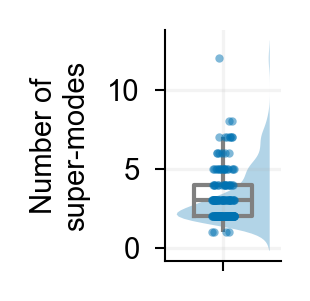

In [46]:
num_modes_all = []
for sub, group in merged_pis_df.groupby('sub'):
    num_modes_all+= [len(group)]

fig, ax = plt.subplots(1, 1, figsize=(0.5, 1))
sns.violinplot(
    data=num_modes_all, 
    ax=ax, 
    split=True,
    inner=None,
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=num_modes_all, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=num_modes_all, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

ax.set(
    title=f'',
    ylabel=f'Number of\nsuper-modes',
)
ax.grid(alpha=0.15)
sns.despine(ax=ax)

In [47]:
np.median(num_modes_all), stats.mode(num_modes_all, keepdims=True).mode

(np.float64(3.0), array([2]))

In [48]:
np.percentile(num_modes_all, q=[2.5, 97.5])

array([2., 7.])

In [49]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-num-modes.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-num-modes.png', transparent=True, dpi=300, bbox_inches='tight')

In [50]:
def get_dist_mat(pis_ref, pis_sub, dist_func=pearson_dist):
    n_ref = len(pis_ref)
    n_sub = len(pis_sub)

    dist_mat = np.zeros((n_ref, n_sub))

    for i in range(n_ref):
        for j in range(n_sub):
            d = dist_func(pis_ref[i], pis_sub[j])
            dist_mat[i, j] = d # in the range [0, 2]
    return dist_mat

---

In [51]:
# bootstrapping

In [52]:
pis_ref = merged_pis_df[merged_pis_df['sub'].isin(['grp'])][col].to_list()
subs = merged_pis_df['sub'].unique()

valid_matches = np.full((len(subs), len(pis_ref)), np.nan)
valid_dists = np.full_like(valid_matches, np.nan)
valid_omegas = np.full_like(valid_matches, np.nan)

In [53]:
for idx_sub, (sub, group) in tqdm(enumerate(merged_pis_df.groupby('sub'))):
    pis_sub = group[col].to_list()
    omegas = group['omega'].to_numpy()
    dist_mat = get_dist_mat(pis_ref, pis_sub)
    row_ind, col_ind = linear_sum_assignment(dist_mat)
    
    valid_matches[idx_sub, row_ind] = col_ind
    valid_dists[idx_sub, row_ind] = dist_mat[row_ind, col_ind]
    valid_omegas[idx_sub, row_ind] = omegas[col_ind]
    # break

0it [00:00, ?it/s]

181it [00:00, 289.40it/s]


In [54]:
subs = [sub for sub, group in merged_pis_df.groupby('sub')]
matches_df = pd.DataFrame(valid_matches, columns=[f'mode {i+1:02d}' for i in range(len(pis_ref))], index=subs).reset_index(names='sub')
dists_df = pd.DataFrame(valid_dists, columns=[f'mode {i+1:02d}' for i in range(len(pis_ref))], index=subs).reset_index(names='sub')
omegas_df = pd.DataFrame(valid_omegas, columns=[f'mode {i+1:02d}' for i in range(len(pis_ref))], index=subs).reset_index(names='sub')

In [55]:
matches_df

sub  mode 01  mode 02  mode 03  mode 04  mode 05
0     00      2.0      4.0      0.0      3.0      5.0
1     01      NaN      NaN      NaN      0.0      NaN
2     02      1.0      0.0      2.0      4.0      3.0
3     03      0.0      NaN      1.0      2.0      NaN
4     04      NaN      NaN      NaN      NaN      0.0
..   ...      ...      ...      ...      ...      ...
176   84      2.0      NaN      0.0      1.0      NaN
177   85      1.0      NaN      0.0      2.0      NaN
178   87      NaN      NaN      0.0      1.0      NaN
179   89      1.0      NaN      0.0      NaN      NaN
180  grp      0.0      1.0      2.0      3.0      4.0

[181 rows x 6 columns]

In [56]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-hierarchical_desc-valid-matches.pkl', 'wb') as f:
    pickle.dump(matches_df, f)
    
with open(f'{folder}/method-hierarchical_desc-valid-dists.pkl', 'wb') as f:
    pickle.dump(dists_df, f)

with open(f'{folder}/method-hierarchical_desc-valid-omegas.pkl', 'wb') as f:
    pickle.dump(omegas_df, f)

In [57]:
def get_align_pis(merged_pis_df, matches_df):
    aligned_data = []
    for _, row in tqdm(matches_df.iterrows(), total=len(matches_df)):
        sub = row['sub']
        
        sub_modes_df = merged_pis_df[merged_pis_df['sub'] == sub]
        local_pis_residuals = sub_modes_df['pi'].to_list()
        local_omegas = sub_modes_df['omega'].to_list()
        
        assert len(local_pis_residuals) == len(local_omegas)
        
        for col in matches_df.columns:
            if not col.startswith('mode'):
                continue
            
            ref_mode_name = col # e.g. mode 01
            
            local_idx = row[col]
            if not pd.notna(local_idx):
                continue
            
            local_idx = int(local_idx)
            if local_idx < len(local_pis_residuals):
                pi_aligned = local_pis_residuals[local_idx] + mean_pi
                omega = local_omegas[local_idx]
                
                pi_aligned = np.clip(pi_aligned, 0, 1)
                
                aligned_data.append({
                    'sub': sub, 
                    'super_mode': ref_mode_name, 
                    'pi_aligned': pi_aligned,
                    'omega': omega,
                })
    aligned_pis_df = pd.DataFrame(aligned_data)
    return aligned_pis_df

In [58]:
aligned_pis_df = get_align_pis(merged_pis_df, matches_df)
aligned_pis_df

100%|██████████| 181/181 [00:00<00:00, 2684.79it/s]


sub super_mode                                         pi_aligned  \
0     00    mode 01  [[0.8483659885452678, 0.0, 0.09019733848686834...   
1     00    mode 02  [[0.45227272727272727, 0.0, 0.4727272727272727...   
2     00    mode 03  [[0.041480992414466955, 0.004175084175084179, ...   
3     00    mode 04  [[0.8459903242342689, 0.008472375135437415, 0....   
4     00    mode 05  [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...   
..   ...        ...                                                ...   
532  grp    mode 01  [[0.8959045802766508, 0.0, 0.0442791282701433,...   
533  grp    mode 02  [[0.8647741147741148, 0.019230769230769232, 0....   
534  grp    mode 03  [[0.04225352112676056, 0.16901408450704225, 0....   
535  grp    mode 04  [[0.23105590062111803, 0.14285714285714285, 0....   
536  grp    mode 05  [[0.9444444444444444, 0.0, 0.05555555555555558...   

        omega  
0    0.142725  
1    0.031086  
2    0.500108  
3    0.132811  
4    0.002024  
..        ...  
532  0.683759  
533  0.152146  
534  0.071034  
535  0.057237  
536  0.035825  

[537 rows x 4 columns]

In [59]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-hierarchical_desc-aligned-pis.pkl', 'wb') as f:
    pickle.dump(aligned_pis_df, f)

In [60]:
boot_estimates_weighted = []
for sub, group in aligned_pis_df.groupby('sub'):
    pis = np.stack(group['pi_aligned'].to_list())
    omegas = group['omega'].to_list()
    
    if np.sum(omegas) > 0:
        # omegas = omegas / np.sum(omegas)
        omegas = np.ones(len(pis)) / len(pis)
    else:
        omegas = np.ones(len(pis)) / len(pis)
    
    boot_est = np.average(pis, axis=0, weights=omegas)
    boot_estimates_weighted.append(boot_est)
boot_estimates_weighted = np.stack(boot_estimates_weighted)

In [61]:
boot_mean_map = np.mean(boot_estimates_weighted, axis=0)
ci_lower = np.percentile(boot_estimates_weighted, 2.5, axis=0)
ci_upper = np.percentile(boot_estimates_weighted, 97.5, axis=0)
ci_width = ci_upper - ci_lower
boot_std_map = np.std(boot_estimates_weighted, axis=0)

std_bounds_map = np.sqrt((1 - boot_est) * (boot_est - 0))
safe_max_std = std_bounds_map.copy()
safe_max_std[safe_max_std < 1e-6] = 1.0 # Placeholder to avoid NaN
instability_ratio = boot_std_map / safe_max_std
instability_ratio = np.nan_to_num(instability_ratio)

bias = boot_mean_map - boot_est # this boot_est corresponds to the last boot, which is the reference sample
avg_bias = np.mean(np.abs(bias))
avg_bias

np.float64(0.03357654804723291)

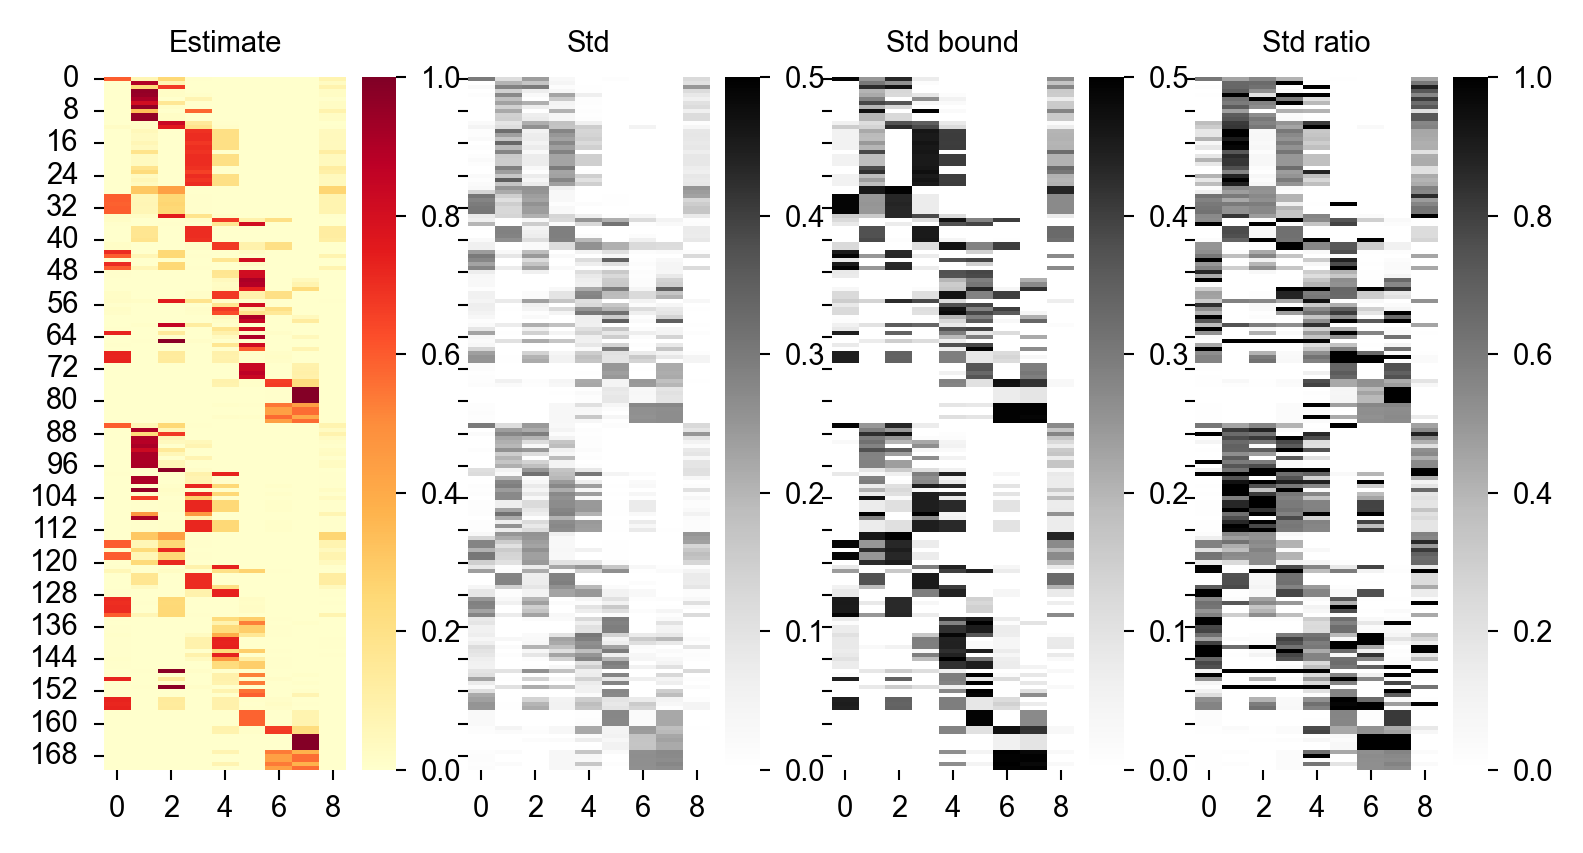

In [62]:
nrows, ncols = 1, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(1.5*ncols, 3.0*nrows))

ax = axs[0]
sns.heatmap(
    boot_est, 
    ax=ax, 
    cmap='YlOrRd', #cmc.batlow,
    vmin=0, vmax=1,
)
_ = ax.set(title=f'Estimate',) # yticklabels=[])

ax = axs[1]
sns.heatmap(
    boot_std_map, 
    ax=ax, 
    cmap='Greys', #cmc.batlow,
    vmin=0, vmax=0.5,
)
_ = ax.set(title=f'Std', yticklabels=[])

ax = axs[2]
sns.heatmap(
    std_bounds_map, 
    ax=ax, 
    cmap='Greys', #cmc.batlow,
    vmin=0, vmax=0.5,
)
_ = ax.set(title=f'Std bound', yticklabels=[])

ax = axs[3]
sns.heatmap(
    instability_ratio, 
    ax=ax, 
    cmap='Greys', #cmc.batlow,
    vmin=0, vmax=1.0,
)
_ = ax.set(title=f'Std ratio', yticklabels=[])

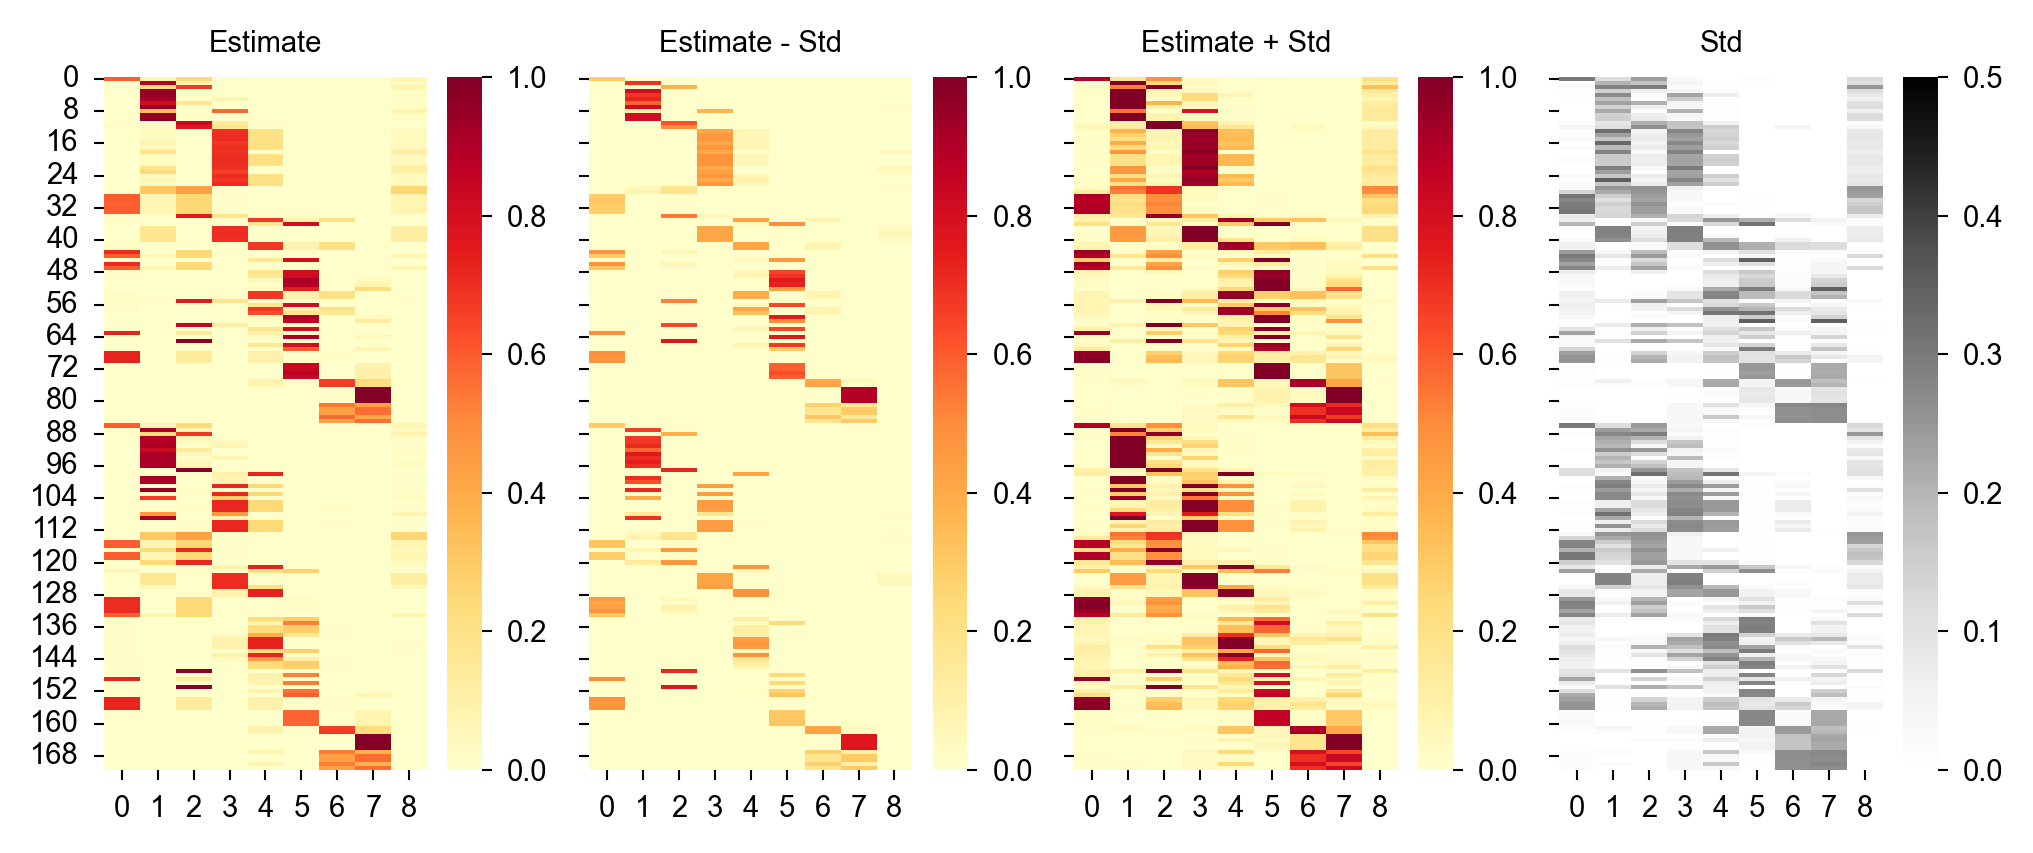

In [65]:
nrows, ncols = 1, 4
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 3.0*nrows))

ax = axs[0]
sns.heatmap(
    boot_est, 
    ax=ax, 
    cmap='YlOrRd', #cmc.batlow,
    vmin=0, vmax=1,
)
_ = ax.set(title=f'Estimate',) # yticklabels=[])

ax = axs[1]
sns.heatmap(
    boot_est - boot_std_map, 
    ax=ax, 
    cmap='YlOrRd', #cmc.batlow,
    vmin=0, vmax=1.0,
)
_ = ax.set(title=f'Estimate - Std', yticklabels=[])

ax = axs[2]
sns.heatmap(
    boot_est + boot_std_map, 
    ax=ax, 
    cmap='YlOrRd', #cmc.batlow,
    vmin=0, vmax=1.0,
)
_ = ax.set(title=f'Estimate + Std', yticklabels=[])


ax = axs[3]
sns.heatmap(
    boot_std_map, 
    ax=ax, 
    cmap='Greys', #cmc.batlow,
    vmin=0, vmax=0.5,
)
_ = ax.set(title=f'Std', yticklabels=[])

In [66]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

with open(f'{folder}/method-hierarchical_desc-mean+std.pkl', 'wb') as f:
    pickle.dump([boot_est, boot_std_map, std_bounds_map, instability_ratio], f)

In [64]:
np.round(instability_ratio, decimals=2)

array([[0.61, 0.46, 0.55, ..., 0.  , 0.  , 0.46],
       [0.  , 0.67, 0.65, ..., 0.  , 0.  , 0.61],
       [0.02, 0.67, 0.63, ..., 0.  , 0.  , 0.88],
       ...,
       [0.01, 0.  , 0.  , ..., 0.53, 0.54, 0.  ],
       [0.01, 0.02, 0.  , ..., 0.53, 0.57, 0.04],
       [0.01, 0.  , 0.  , ..., 0.53, 0.54, 0.  ]], shape=(172, 9))

In [60]:
recovery_rate = matches_df.count() / len(matches_df)
recovery_rate

sub        1.000000
mode 01    0.624309
mode 02    0.602210
mode 03    0.624309
mode 04    0.552486
mode 05    0.563536
dtype: float64

In [61]:
# null testing

In [62]:
def get_shuffled_mats(pis):
    row_shuffle = np.random.permutation(args.num_rois)
    pis_shuffled = [pi[row_shuffle, :] for pi in pis]
    return pis_shuffled

In [63]:
num_null = 100
null_valid_matches = np.full((len(subs), len(pis_ref), num_null), np.nan)
null_valid_dists = np.full_like(null_valid_matches, np.nan)
null_valid_omegas = np.full_like(null_valid_matches, np.nan)

In [64]:
for idx_null in tqdm(range(num_null)):
    for idx_sub, (sub, group) in (enumerate(merged_pis_df.groupby('sub'))):
        pis_sub = group[col].to_list()
        omegas = group['omega'].to_numpy()
        pis_sub_shuffled = get_shuffled_mats(pis_sub)
        dist_mat = get_dist_mat(pis_ref, pis_sub_shuffled)
        row_ind, col_ind = linear_sum_assignment(dist_mat)
        
        null_valid_matches[idx_sub, row_ind, idx_null] = col_ind
        null_valid_dists[idx_sub, row_ind, idx_null] = dist_mat[row_ind, col_ind]
        null_valid_omegas[idx_sub, row_ind, idx_null] = omegas[col_ind]
        # break

100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


In [65]:
valid_pvalues = np.nanmean(null_valid_dists <= valid_dists[:, :, None], axis=-1)
valid_pvalues[np.isnan(valid_dists)] = np.nan
# valid_pvalues

In [66]:
null_dict = {}
for idx_ref in range(len(pis_ref)):
    null_dict[f'mode {idx_ref+1:02d}'] = null_valid_dists[:, idx_ref, :].flatten()

In [67]:
null_valid_dists = np.stack(list(null_dict.values()), axis=1)

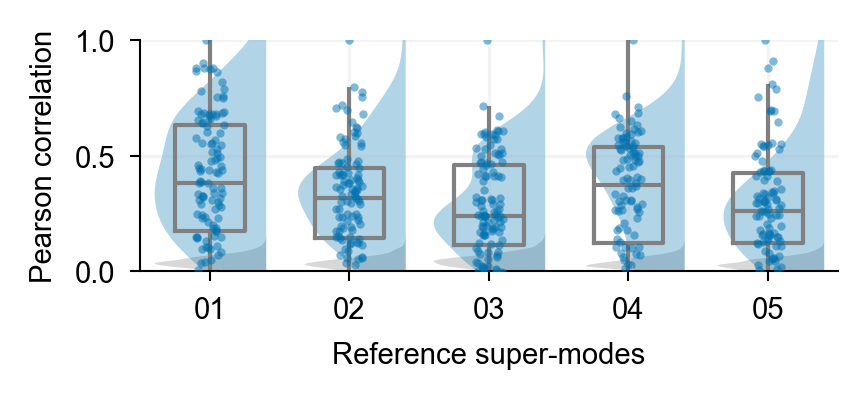

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.0))

sns.violinplot(
    data=1 - null_valid_dists[::20, :], 
    ax=ax, 
    split=True,
    inner=None,
    density_norm='count',
    color='grey',
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)


sns.violinplot(
    data=1 - valid_dists, 
    ax=ax, 
    split=True,
    inner=None,
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=1 - valid_dists, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=1 - valid_dists, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

sns.despine(ax=ax)
ymax=1.0
ax.set(
    xlabel='Reference super-modes', 
    xticklabels=[f'{i+1:02d}' for i in range(valid_dists.shape[1])],
    ylabel=f'Pearson correlation',
    ylim=[-0.0, ymax],
)
# for i in range(valid_omegas.shape[-1]):
#     ax.text(i, ymax, f'{recovery_rate[i]:.2f}', ha='center', va='bottom')
ax.grid(alpha=0.15)

In [69]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-distances.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-distances.png', transparent=True, dpi=300, bbox_inches='tight')

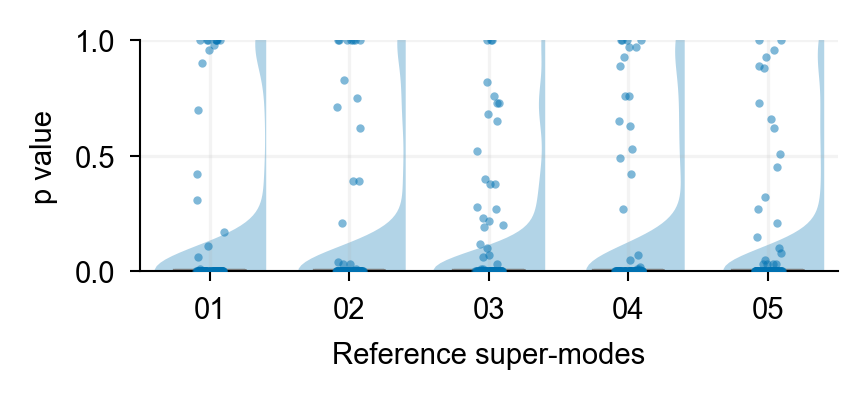

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.0))

sns.violinplot(
    valid_pvalues,
    ax=ax, 
    split=True,
    inner=None, 
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=valid_pvalues, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=valid_pvalues, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

sns.despine(ax=ax)
ymax=1.0
ax.set(
    xlabel='Reference super-modes', 
    xticklabels=[f'{i+1:02d}' for i in range(valid_pvalues.shape[1])],
    ylabel=f'p value',
    ylim=[0, ymax],
)
# for i in range(valid_omegas.shape[-1]):
#     ax.text(i, ymax, f'{recovery_rate[i]:.2f}', ha='center', va='bottom')
ax.grid(alpha=0.15)

In [71]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-pvalues.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-pvalues.png', transparent=True, dpi=300, bbox_inches='tight')

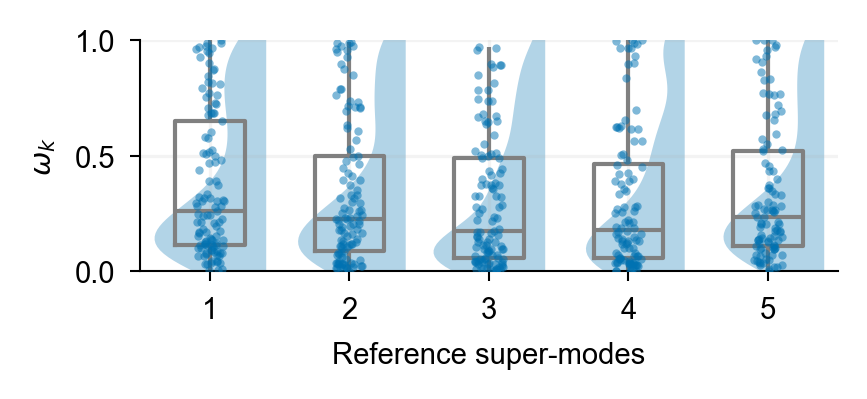

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(3, 1.0))

sns.violinplot(
    data=valid_omegas,
    ax=ax,
    split=True,
    inner=None, 
    density_norm='count',
    color=CUD_COLORS[0],
    linecolor='grey',
    linewidth=0,
    saturation=1.0,
    alpha=0.3,
)

sns.boxplot(
    data=valid_omegas, 
    ax=ax,
    color='grey',
    fill=False, 
    width=0.5, 
    linewidth=1,
    fliersize=0,
    capprops=dict(linewidth=0),
)

sns.stripplot(
    data=valid_omegas, 
    ax=ax,
    color=CUD_COLORS[0],
    size=2,
    marker='o',
    alpha=0.5, 
    jitter=True,
)

# sns.stripplot(
#     data=valid_omegas[-1, :][None, :], 
#     ax=ax,
#     color=CUD_COLORS[1],
#     size=3, 
#     marker='o',
#     alpha=0.5,
#     jitter=False
# )

ax.grid(alpha=0.15)
sns.despine(ax=ax)
ymax = 1.0
_ = ax.set(xlabel='Reference super-modes', ylabel=r'$\omega_k$', ylim=[0.0, ymax], xticklabels=range(1, 13))
# for i in range(valid_omegas.shape[-1]):
#     ax.text(i, ymax, f'{recovery_rate[i]:.2f}', ha='center', va='bottom')

In [73]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-omegas.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-aligned-valid-omegas.png', transparent=True, dpi=300, bbox_inches='tight')

---

In [74]:
valid_omegas_ = valid_omegas.copy()
valid_omegas_[np.isnan(valid_omegas_)] = 0.0
np.round(valid_omegas_, decimals=3)

array([[0.143, 0.031, 0.5  , 0.133, 0.002],
       [0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.066, 0.875, 0.04 , 0.   , 0.018],
       [0.686, 0.   , 0.288, 0.026, 0.   ],
       [0.   , 0.   , 0.   , 0.   , 1.   ],
       [0.072, 0.531, 0.   , 0.   , 0.398],
       [0.   , 0.   , 0.   , 0.   , 1.   ],
       [0.   , 0.   , 0.   , 1.   , 0.   ],
       [0.374, 0.   , 0.009, 0.616, 0.   ],
       [0.   , 0.   , 0.231, 0.   , 0.769],
       [0.   , 0.764, 0.236, 0.   , 0.   ],
       [0.284, 0.265, 0.084, 0.036, 0.331],
       [0.   , 0.949, 0.   , 0.051, 0.   ],
       [0.09 , 0.178, 0.016, 0.131, 0.19 ],
       [0.508, 0.108, 0.384, 0.   , 0.   ],
       [0.   , 0.   , 0.03 , 0.   , 0.97 ],
       [0.084, 0.   , 0.639, 0.212, 0.065],
       [0.   , 0.   , 0.127, 0.837, 0.037],
       [0.114, 0.164, 0.067, 0.22 , 0.073],
       [0.134, 0.075, 0.084, 0.209, 0.288],
       [0.277, 0.061, 0.097, 0.393, 0.173],
       [0.1  , 0.275, 0.513, 0.   , 0.112],
       [0.081, 0.714, 0.   , 0. 

In [75]:
samples = [valid_omegas_[:, i] for i in range(valid_omegas_.shape[-1])]

In [76]:
stat_f, p_f = stats.friedmanchisquare(*samples)
stat_f, p_f

(np.float64(3.052369077307047), np.float64(0.5491001334236085))

In [77]:
stat_k, p_k = stats.kruskal(*samples, nan_policy='omit')
stat_k, p_k

(np.float64(5.24775833659099), np.float64(0.26280732423799835))

In [78]:
test_mat = np.zeros((valid_omegas_.shape[1], valid_omegas_.shape[1]))
for (i, j) in combinations(range(valid_omegas_.shape[1]), 2):
    _, p = wilcoxon(
        valid_omegas_[:, i],
        valid_omegas_[:, j], 
        alternative='two-sided', 
        nan_policy='omit',
    )
    test_mat[i, j] = p
    test_mat[j, i] = test_mat[i, j]

[Text(0.5, -20.166666666666675, 'Reference super-modes'),
 Text(30.83333333333339, 0.5, 'Reference super-modes'),
 Text(0.5, 1.0, 'Paired test, p value')]

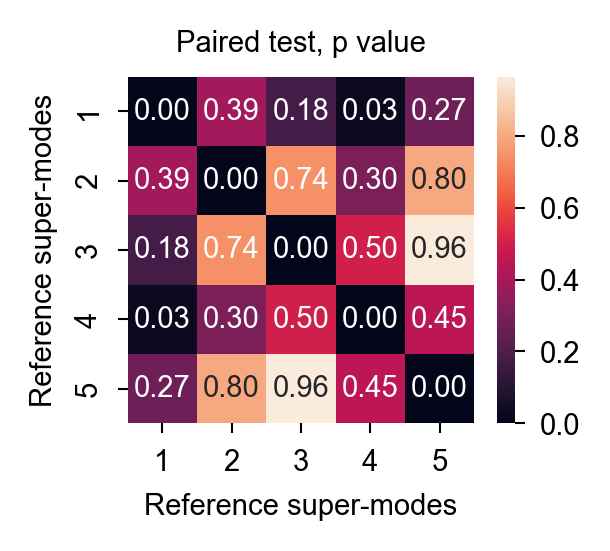

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
sns.heatmap(
    test_mat, 
    ax=ax, 
    square=True,
    annot=True,
    fmt='.2f',
)
ax.set(xticklabels=range(1, test_mat.shape[1]+1), yticklabels=range(1, test_mat.shape[0]+1))
ax.set(xlabel='Reference super-modes', ylabel='Reference super-modes', title=f'Paired test, p value')

In [80]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-super-modes-paired-testing-omega.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-super-modes-paired-testing-omega.png', transparent=True, dpi=300, bbox_inches='tight')

we did not detect a clear ranking/hierarchy among any pair of super-modes. i.e. $\omega_k$ of no mode was strictly greater than the other in majority of the resamples.

In [81]:
test_mat = np.zeros((valid_omegas.shape[1], valid_omegas.shape[1]))
for (i, j) in combinations(range(valid_omegas.shape[1]), 2):
    x = valid_omegas[:, i]
    y = valid_omegas[:, j]
    p = (x > y).mean()
    test_mat[i, j] = p
    test_mat[j, i] = test_mat[i, j]

<Axes: >

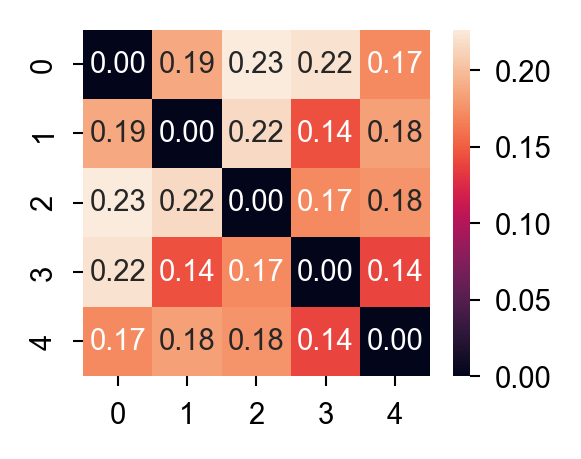

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.5))
sns.heatmap(
    test_mat, 
    ax=ax, 
    square=True,
    annot=True,
    fmt='.2f',
)

---

In [83]:
group = merged_pis_df[merged_pis_df['sub'].isin(['grp'])].reset_index(drop=True)
group['pi_full'] = group['pi'].apply(lambda pi: pi + mean_pi)
group

sub       sbm     omega                                                 pi  \
0  grp  sbm-nd-h  0.683759  [[0.36318294526428324, -0.04660824830236906, -...   
1  grp  sbm-nd-h  0.152146  [[0.33205247976174734, -0.027377479071599826, ...   
2  grp  sbm-nd-h  0.071034  [[-0.4904681138856069, 0.12240583620467319, 0....   
3  grp  sbm-nd-h  0.057237  [[-0.30166573439124944, 0.09624889455477378, -...   
4  grp  sbm-nd-h  0.035825  [[0.41172280943207695, -0.04660824830236906, -...   

                                                 sil  \
0      k                                  labels ...   
1      k                                  labels ...   
2      k                                  labels ...   
3      k                                  labels ...   
4      k                                  labels ...   

                                             pi_full  
0  [[0.8959045802766508, 0.0, 0.0442791282701433,...  
1  [[0.8647741147741148, 0.019230769230769232, 0....  
2  [[0.04225352112676056, 0.16901408450704225, 0....  
3  [[0.23105590062111803, 0.14285714285714285, 0....  
4  [[0.9444444444444444, 0.0, 0.05555555555555558...

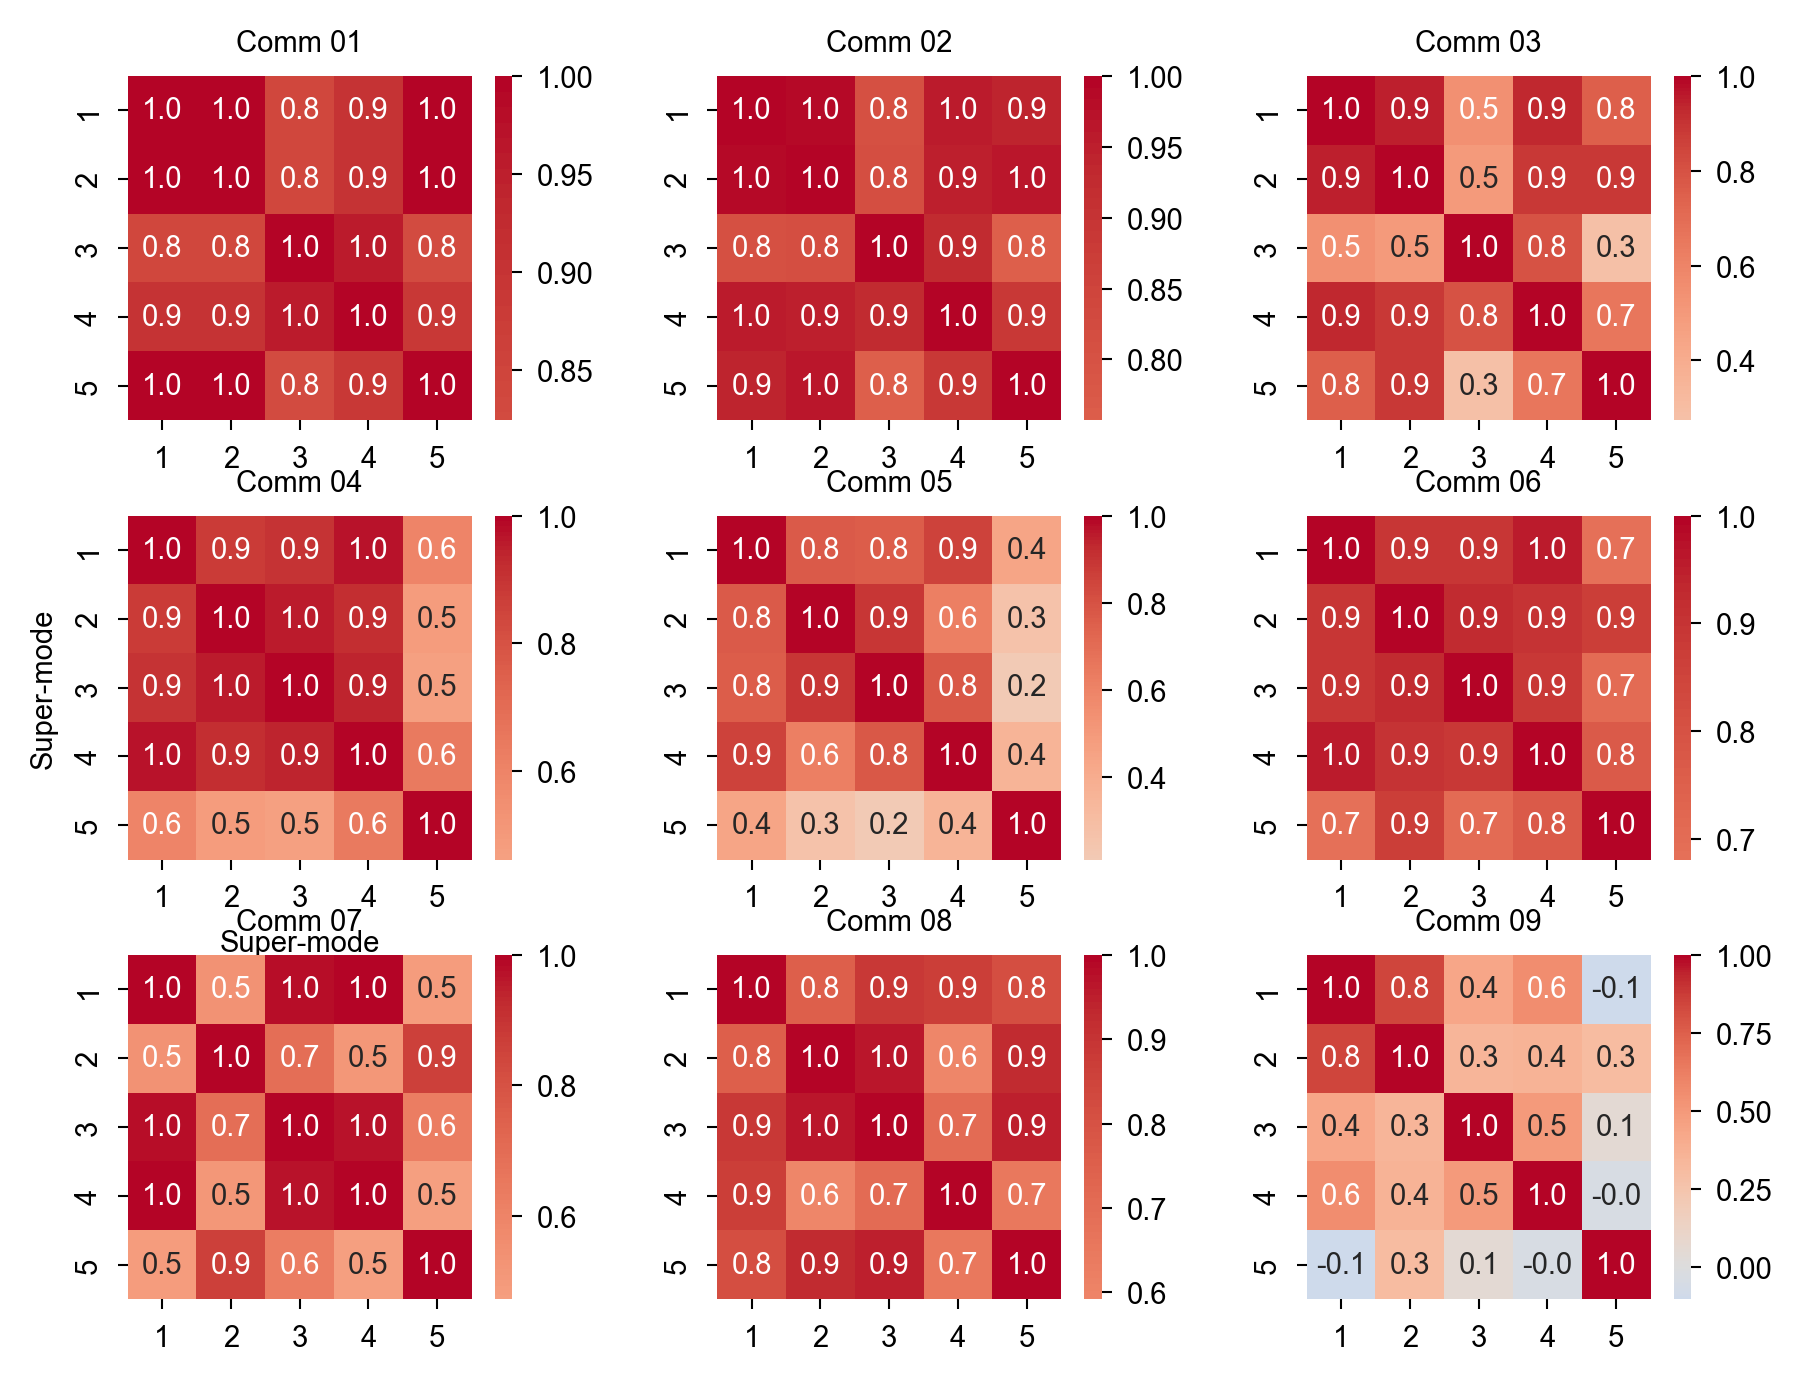

In [84]:
pis = np.stack(group['pi_full'].to_list())
corrs = np.zeros((pis.shape[-1], pis.shape[0], pis.shape[0]))
for idx_comm in range(pis.shape[-1]):
    X = pis[:, :, idx_comm]
    corrs[idx_comm, :, :] = 1 - cdist(X, X, metric='correlation')

ncols = 3
nrows = np.ceil(corrs.shape[0] / ncols).astype('int')
fig, axs = plt.subplots(nrows, ncols, figsize=(2*ncols, 1.5*nrows))
fig.tight_layout()
for idx_comm in range(corrs.shape[0]):
    r, c = idx_comm // ncols, idx_comm % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    
    sns.heatmap(
        corrs[idx_comm, :, :], 
        ax=ax, 
        cmap='coolwarm', center=0, 
        square=True,
        annot=True, fmt='.1f',
    )
    ax.set(
        title=f'Comm {idx_comm+1:02d}',
        xlabel=f'Super-mode' if (r == 1) & (c == 0) else '',
        ylabel=f'Super-mode' if (r == 1) & (c == 0) else '',
        xticklabels=[f'{i+1}' for i in range(corrs.shape[-1])],
        yticklabels=[f'{i+1}' for i in range(corrs.shape[-1])],
    )

In [85]:
folder = f'{ESTIM_path}/group/multiplicity/partition/{SBM}'
os.makedirs(folder, exist_ok=True)

fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-comm-correlations.svg', transparent=True, dpi=300, bbox_inches='tight')
fig.savefig(f'{folder}/level-{level}_method-hierarchical_desc-comm-correlations.png', transparent=True, dpi=300, bbox_inches='tight')